### Setup

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback

2023-09-11 15:09:05.777546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:09:07.511160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 15:09:07.517976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 15:09:25.548998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


- Multiclass (X)
- Multilable (X) -- check how or if to normalize output // select cutoff for predicting charge as present
- Prosit (X)
- Multi-head Binary Classifier (Omar) (TODO)

- Split for all of them (X) 
- Training (X)
- Inference (X?) 
- Analysis (X)
    - TopK
----------------------
----------------------
- Clean up code for presentation (TODO?) 
- Presentation (TODO)

### Data preprocessing
- remove all columns except: 'modified_sequence', 'precursor_charge', 'precursor_intensity'
- filter out unwanted charge states
- filter for most abundant charge state per sequence by precursor_intensity after normalizing the values
- filter sequence length according to occurance in dataset (currently less than 100 sequences of a certain length get removed)
- search for occurences of UNIMOD modifications and add them to the vocabulary
- generate continous sequence encoding // first layer - embedding layer
- generate precursor_charge one-hot encoding

### Preprocessing functions

In [3]:
'''
Combine files into one dataframe and keep only desired columns
Default: 
- dir_path = 'data/'
- file_type = '.parquet'
Default: drop everything except: modified_sequence, precursor_charge and precursor_intensity
- columns_to_keep = ['modified_sequence','precursor_charge','precursor_intensity']
'''
def combine_parquet_into_df(dir_path='data/', file_type='.parquet', columns_to_keep=['modified_sequence','precursor_charge','precursor_intensity']):
    dfs = [] 
    for file in os.listdir(dir_path):
        if file.endswith(file_type):
            file_path = os.path.join(dir_path, file)
            df = pd.read_parquet(file_path, engine='fastparquet')
            df = df[columns_to_keep]
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    return df

In [4]:
'''
Drop all rows with NaN values in a specific column
Default: drop na from precursor_intensity column
'''
def drop_na(df, column='precursor_intensity'):
    df = df[df[column].notna()]
    return df

In [5]:
'''
Keep only desired charge entires
Default: keep charges 1-6
'''
def keep_desired_charges(df, charge_list=[1, 2, 3, 4, 5, 6]):
    df = df[df['precursor_charge'].isin(charge_list)]
    return df

In [6]:
'''
Find all UNIMOD annotations and add them to the vocabulary
(The length of the vocabulary +1 is used later for the embedding layer)
'''
def complete_vocabulary(df):
    """
    Completes the vocabulary with all the possible amino acids and modifications
    :return: list
    """
    vocabulary = []
    vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)
    vocab_len = len(vocabulary)
    return vocabulary, vocab_len

In [7]:
'''
Combine unique sequences and aggregate their precursor_charges and intensity in order to later select the most abundant charge state per sequence.
'''
def aggregate_sequences(df):
    df = df.groupby("modified_sequence")[["precursor_charge", "precursor_intensity"]].agg(list).reset_index()
    return df

In [35]:
'''
Generate overview plot for precursor_charge distribution in combined dataset
'''
def plot_most_abundant_charge_distribution(df):
    # plot the distirbution of precursor_charge for the whole dataset
    sns.set_theme(style="darkgrid")
    sns.set_context("paper")
    ax = sns.countplot(x='most_abundant_charge', data=df, palette="viridis")
    plt.xlabel('Precursor Charge')
    plt.ylabel('Count')
    plt.title('Distribution of Precursor Charge')
    # add percentage of each charge state to the plot
    total = len(df['most_abundant_charge'])
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() + 5
        ax.annotate(percentage, (x, y))
    plt.show()

In [9]:
# TODO
'''
Normalize precursor intensities for aggregated sequences
'''
def normalize_precursor_intensities(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
            charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [10]:
# TODO
'''
Select most abundand charge state per unique sequence according to the normalized precursor intensity
'''
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)

In [11]:
'''
One-Hot encode most abundand charge state
input: df with "most_abundance_charge" column
output: new column "most_abundant_charge_vector" containing one-hot encoded vector
'''
def one_hot_encode_charge(df, charge_list=[1, 2, 3, 4, 5, 6]):
    df['most_abundant_charge_vector'] = df['most_abundant_charge'].apply(lambda x: [1 if x == i else 0 for i in charge_list])
    return df

In [30]:
# TODO: description
'''
Applying normalization, selecting most abundant charge state and one-hot encoding
'''
def normalize_and_select_most_abundant(df):
    df['normalized'] = df.apply(lambda x: normalize_precursor_intensities(x["precursor_charge"], x["precursor_intensity"]), axis=1)
    df['pre_normalization'] = df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)
    df['most_abundant_charge'] = df['normalized'].apply(lambda x: max(x, key=x.get))
    df = one_hot_encode_charge(df)
    return df

In [13]:
'''
Remove sequences of specific length represented less than a certain number of times

input: df containig "modified_sequence" column, representation_threshold
output: 
- df containing only sequence legths represented more than representation_threshold times
- padding_length
default: representation_threshold = 100

Calculate the sequence lengths and their counts
Filter out sequences with counts below the threshold
Filter the original DataFrame based on sequence length
Drop the temporary column
'''
def remove_rare_sequence_lengths(df, representation_threshold=100):
    df['sequence_length_prepadding'] = df['modified_sequence'].apply(len)
    len_counts = df['sequence_length_prepadding'].value_counts().reset_index()
    len_counts.columns = ['seq_len', 'count']
    filtered_lengths = len_counts[len_counts['count'] >= representation_threshold]['seq_len']
    df = df[df['sequence_length_prepadding'].isin(filtered_lengths)].copy()
    padding_length = df['sequence_length_prepadding'].max()
    df = df[df['sequence_length_prepadding'].isin(filtered_lengths)]
    # df.drop(columns=['sequence_length_prepadding'], inplace=True)
    return df, padding_length

In [37]:
'''
Encode all occuring charge states per unique sequence in a binary vector

input: df containing "precursor_charge" column
output: df containing an additional "charge_state_vector" column encoding all occuring charge states per unique sequence in a binary vector
'''
def encode_charge_states(df):
    df['charge_state_vector'] = df['precursor_charge'].apply(lambda x: [1 if i in x else 0 for i in range(1,7)])
    return df

In [40]:
# TODO 
'''
Filter Sequences 'skipping a charge' eg [1,1,0,1,0,0]

input: df containing "charge_state_vector" column
output: remove all sequences skipping a charge
'''
def filter_skipped_charges(df):
    df = df[df['charge_state_vector'].apply(lambda x: 1 not in [x[i] + x[i+1] for i in range(len(x)-1)])]
    return df

In [42]:
data = {'charge_state_vector': [[1, 1, 0, 1, 0, 0],
                                [1, 0, 0, 1, 1, 0],
                                [0, 0, 0, 0, 0, 0],
                                [1, 0, 1, 0, 0, 1],
                                [0, 0, 0, 1, 0, 0]], 
        'modified_sequence': ['AAAAAA', 'BBBBBB', 'CCCCCC', 'DDDDDD', 'EEEEEE']}

test_df = pd.DataFrame(data)

# Filter sequences skipping a charge
filtered_test_df = filter_skipped_charges(test_df)

print("Original DataFrame:")
print(test_df)

print("\nFiltered DataFrame:")
print(filtered_test_df)

Original DataFrame:
  charge_state_vector modified_sequence
0  [1, 1, 0, 1, 0, 0]            AAAAAA
1  [1, 0, 0, 1, 1, 0]            BBBBBB
2  [0, 0, 0, 0, 0, 0]            CCCCCC
3  [1, 0, 1, 0, 0, 1]            DDDDDD
4  [0, 0, 0, 1, 0, 0]            EEEEEE

Filtered DataFrame:
  charge_state_vector modified_sequence
2  [0, 0, 0, 0, 0, 0]            CCCCCC


In [16]:
"""
Encodes the 'modified_sequence' column in a DataFrame and adds a new column 'modified_sequence_vector'.

input: df containing "modified_sequence" column, vocabulary, padding_length
output: df containing "modified_sequence_vector" column with padded and encoded sequences

defaults: padding_length = 50
"""
def sequence_encoder(df, padding_length=50, vocabulary=None):
    
    if 'modified_sequence' not in df.columns:
        raise ValueError("DataFrame must contain a 'modified_sequence' column.")

    aa_dictionary = {aa: index for index, aa in enumerate(vocabulary)}

    def encode_sequence(sequence):
        pattern = r'[A-Z]\[[^\]]*\]|.'
        result = [match for match in re.findall(pattern, sequence)]
        result += ['X'] * (padding_length - len(result))
        return [aa_dictionary.get(aa, aa_dictionary['X']) for aa in result]

    df['modified_sequence_vector'] = df['modified_sequence'].apply(encode_sequence)
    return df

## Preprocessing

In [17]:
dir_path = 'data/'
file_type = '.parquet'
max_seq_len = 0

In [18]:
df = combine_parquet_into_df(dir_path, file_type)

In [19]:
df = drop_na(df, 'precursor_intensity')

In [20]:
df = keep_desired_charges(df)

In [21]:
df = aggregate_sequences(df)

In [23]:
df, padding_length = remove_rare_sequence_lengths(df)

In [24]:
vocabulary, voc_len = complete_vocabulary(df)

In [25]:
df = sequence_encoder(df, padding_length, vocabulary)

In [31]:
df = normalize_and_select_most_abundant(df)

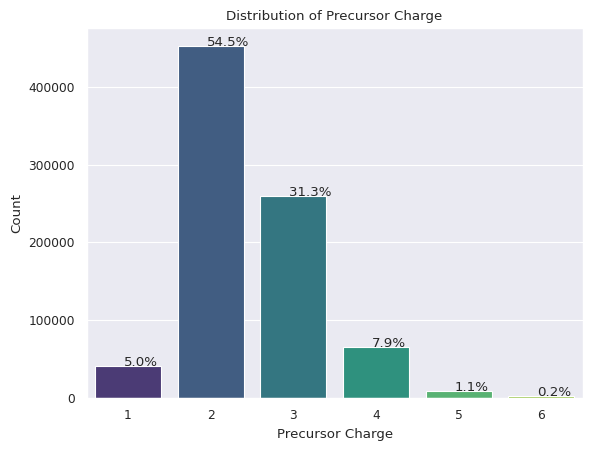

In [34]:
plot_most_abundant_charge_distribution(df)

In [36]:
df.head()

,modified_sequence,precursor_charge,precursor_intensity,sequence_length_prepadding,modified_sequence_vector,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]"
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]"
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ...",{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]"


In [38]:
df = encode_charge_states(df)
df.head()

,modified_sequence,precursor_charge,precursor_intensity,sequence_length_prepadding,modified_sequence_vector,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,charge_state_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 0, 0, 0]"
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]"
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ...",{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"


# Models

General idea:
Input: mod_seq_encoded, precursor_charge // precursor_charge_onehot
Output: 5 nodes --> highest value == most probable charge for input sequence
Use: Softmax, Crossentropy loss

stratified split:
- PROSITE
- CCE
- SCCE // ?

evaluate models by:
- categorical accuracy
- f1 score // ?

#### Stratified split for all models
Split into train_val and test by unique sequence 

Split into train and val via stratified split

In [41]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#### CCE

In [46]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Input

inputA_embed = Input(shape=train_ds_embed[0].shape)
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
y = Dense(max_len_seq, activation="relu")(y)
z = Dense(num_classes, activation="softmax")(y)
multiclass_model = Model(inputs=[x.input], outputs=z)

In [ ]:
multiclass_model.summary()

In [ ]:
tf.keras.utils.plot_model(multiclass_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Define callbacks for multiclass model
checkpoint_callback_multiclass_model = ModelCheckpoint('checkpoints/multiclass_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_multiclass_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Compile the model
multiclass_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [ ]:
# training with stratified split
# save history of model training
history_multiclass_model = multiclass_model.fit(train_ds_embed, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()])

### Anaylsis / Plots etc.

In [49]:
# eval

## Postprocessing

In [35]:
def generate_charge_prediction_text(charge_predictions):
    max_charge_index = np.argmax(charge_predictions)
    max_charge_value = round(charge_predictions[max_charge_index], 2)

    charge_text = f"The predicted charge state for the input sequence is {max_charge_index+1} [{round(max_charge_value*100,2)}%]."
    percentage_text = "Prediction percentages for other states:\n"

    for index, prediction in enumerate(charge_predictions):
        if index != max_charge_index:
            percentage = round(prediction * 100, 2)
            percentage_text += f"Charge state {index+1}: {percentage}%\n"

    full_text = charge_text + "\n" + percentage_text
    return full_text


# Beispiel
charge_predictions = np.array([0, 0.3, 0.53, 0.17, 0, 0])
output_text = generate_charge_prediction_text(charge_predictions)
print(output_text)

The predicted charge state for the input sequence is 3 [53.0%].
Prediction percentages for other states:
Charge state 1: 0.0%
Charge state 2: 30.0%
Charge state 4: 17.0%
Charge state 5: 0.0%
Charge state 6: 0.0%

